In [192]:
###########################################################
#Title: Daily sale prediction using machine learning     ##
#Author: Pair Phongphaew, Salma EL HASSANI, Michael Zhou ##
#Date : Feb 14, 2023                                     ##
###########################################################

In [269]:
import pandas as pd 
import numpy as np          # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs 
from datetime import datetime as dt   # To access datetime 
from pandas import Series        # To work on series 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [270]:
xls = pd.ExcelFile('online_retail_II.xlsx')
df1 = pd.read_excel(xls, 'Year 2009-2010')
df2 = pd.read_excel(xls, 'Year 2010-2011')

In [271]:
print(df1.keys())
print(df2.keys())

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [272]:
#Find the country that has the most transactions 
group_country_df1 = df1.groupby("Country").count().sort_values(by=['Invoice'],ascending=False)
group_country_df2 = df2.groupby("Country").count().sort_values(by=['Invoice'],ascending=False)
print(group_country_df1.head())
print(group_country_df2.head())

                Invoice  StockCode  Description  Quantity  InvoiceDate  \
Country                                                                  
United Kingdom   485852     485852       482924    485852       485852   
EIRE               9670       9670         9670      9670         9670   
Germany            8129       8129         8129      8129         8129   
France             5772       5772         5772      5772         5772   
Netherlands        2769       2769         2769      2769         2769   

                 Price  Customer ID  
Country                              
United Kingdom  485852       379423  
EIRE              9670         8710  
Germany           8129         8129  
France            5772         5710  
Netherlands       2769         2769  
                Invoice  StockCode  Description  Quantity  InvoiceDate  \
Country                                                                  
United Kingdom   495478     495478       494024    495478       495

Comment: the data in the United Kingdom is big enough to forcast so we are going to focus on the sales throughout the years in this country 

In [273]:
d_UK1 = df1[df1['Country'] == 'United Kingdom']
d_UK2 = df2[df2['Country'] == 'United Kingdom']
#calculate Total = Quantity*Price (total sales)
d_UK1_new = d_UK1.copy() 
d_UK2_new = d_UK2.copy() 
d_UK1_new["total"] = d_UK1["Quantity"]*d_UK1["Price"]
d_UK2_new["total"] = d_UK2["Quantity"]*d_UK2["Price"]
#now drop unneccessay columns 
d_UK1_new = d_UK1_new.drop(['Invoice','Country','Description','Price','Quantity','Customer ID'],axis =1).dropna(axis=0)
d_UK2_new = d_UK2_new.drop(['Invoice','Country','Description','Price','Quantity','Customer ID'],axis =1).dropna(axis=0)

In [274]:
#concat d_UK1 and d_UK2 
frames = [d_UK1_new,d_UK2_new]
d_all = pd.concat(frames,ignore_index=True) #Year 2009 to 2011 
#print(d_all.tail(5))
# InvoiceDate to date only
d_all['InvoiceDate'] = pd.to_datetime(d_all.InvoiceDate)
#print(d_all)

#extract the Year-Month-Day-Hour 
d_all['Year'] = d_all.InvoiceDate.dt.year
d_all['Month'] = d_all.InvoiceDate.dt.month
d_all['Day'] = d_all.InvoiceDate.dt.day
d_all['Hour'] = d_all.InvoiceDate.dt.hour

After looking at the data, we are going to predict the daily sales in United Kingdom

### EDA

Hypothesis
1. the avg sales will be high during the end of the year
2. Sale is high around the beginning of the month

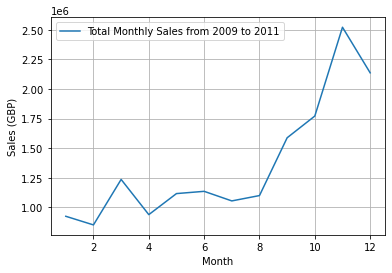

In [275]:
sales_per_month = d_all.groupby('Month')['total'].sum()
plt.plot(sales_per_month)
plt.ylabel('Sales (GBP)')
plt.xlabel('Month')
plt.legend(['Total Monthly Sales from 2009 to 2011'])
plt.grid(True)

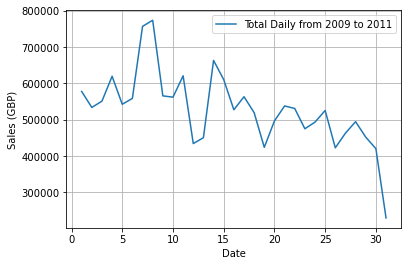

In [276]:
sales_per_day = d_all.groupby('Day')['total'].sum()
plt.plot(sales_per_day) 
plt.ylabel('Sales (GBP)')
plt.xlabel('Date')
plt.legend(['Total Daily from 2009 to 2011'])
plt.grid(True)

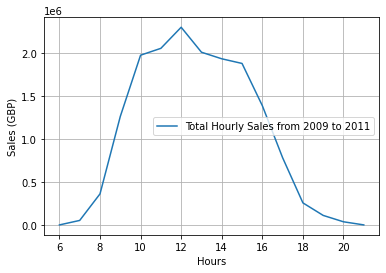

In [277]:
sales_per_hour = d_all.groupby('Hour')['total'].sum()
plt.plot(sales_per_hour) 
plt.ylabel('Sales (GBP)')
plt.xlabel('Hours')
plt.legend(['Total Hourly Sales from 2009 to 2011'])
plt.grid(True)

Spliting data for training, validation, and testing

In [278]:
#print(d_all)
X = d_all.copy()
X = X.set_index('InvoiceDate')
#X = X.drop(['StockCode','Year','Month','Day','Hour'],axis =1)
print(X)

                    StockCode  total  Year  Month  Day  Hour
InvoiceDate                                                 
2009-12-01 07:45:00     85048   83.4  2009     12    1     7
2009-12-01 07:45:00    79323P   81.0  2009     12    1     7
2009-12-01 07:45:00    79323W   81.0  2009     12    1     7
2009-12-01 07:45:00     22041  100.8  2009     12    1     7
2009-12-01 07:45:00     21232   30.0  2009     12    1     7
...                       ...    ...   ...    ...  ...   ...
2011-12-09 12:31:00     22466   23.4  2011     12    9    12
2011-12-09 12:49:00     22061   23.6  2011     12    9    12
2011-12-09 12:49:00     23275   30.0  2011     12    9    12
2011-12-09 12:49:00     21217  214.8  2011     12    9    12
2011-12-09 12:49:00     20685   70.8  2011     12    9    12

[981330 rows x 6 columns]


Resample the total sales by day and drop the day that has zero sale

In [279]:
#resample TOTAL OF THE SAME YEAR-MONTH-DAY
temp = X.total.resample('D').sum()
daily_resampled=temp.to_frame('total')
#print(daily_resampled[daily_resampled['total']==0])
daily_resampled.drop(daily_resampled.loc[daily_resampled['total']==0].index, inplace=True)

                total
InvoiceDate          
2009-12-01   46692.71
2009-12-02   55871.42
2009-12-03   67340.80
2009-12-04   37828.33
2009-12-05    9042.36
...               ...
2011-12-05   54715.25
2011-12-06   50307.31
2011-12-07   55028.58
2011-12-08   78437.90
2011-12-09   27345.03

[604 rows x 1 columns]


Text(0, 0.5, 'total sales (GBP)')

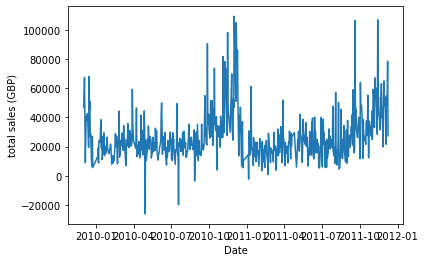

In [280]:
print(daily_resampled)

plt.plot(daily_resampled)
plt.xlabel('Date')
plt.ylabel('total sales (GBP)')

In [349]:
from sklearn.metrics import mean_absolute_percentage_error

In [350]:
# extract the seasonality data
months = [x.month for x in daily_resampled.index]
years = [x.year for x in daily_resampled.index]
day = [x.day for x in daily_resampled.index]

# convert into one matrix
X = np.array([day, months, years]).T
y = daily_resampled.total.values

X_train, y_train = X[:423],y[:423]
X_val, y_val = X[423:484], y[423:484]                                                                        
X_test, y_test = X[484:],y[484:]

After we resampled by day, we have 604 samples and the roughly 70% of samples are going to be our training data. The next 10% will be our validation data, and the remaining 20% will be our test data. 

In [351]:
from datetime import datetime
import time
def x_to_datetime(x):
    date = []
    for i in range(len(x)):
        day = x[i][0]
        month = x[i][1]
        year = x[i][2]
        time_obj = datetime(year,month,day)
        date_str = time_obj.strftime("%Y-%m-%d")
        date.append(date_str)
    return date

In [355]:
X_train_axis = pd.DataFrame(x_to_datetime(X_train)).set_index(0)
X_val_axis = pd.DataFrame(x_to_datetime(X_val)).set_index(0)
X_test_axis = pd.DataFrame(x_to_datetime(X_test)).set_index(0)

### Linear Regression

Training set

In [356]:
from sklearn.linear_model import LinearRegression

my_lr = LinearRegression()
my_lr.fit(X_train, y_train)

# predict on the same period
preds = my_lr.predict(X_train)
mape = mean_absolute_percentage_error(y_train,preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 0.5834318780278862


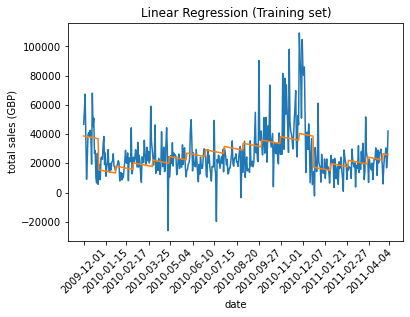

In [357]:
import matplotlib.dates as mdates
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_train_axis.index,y_train)
ax.plot(X_train_axis.index,preds)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title("Linear Regression (Training set)")
plt.show()

Validation set

In [358]:
#val set 
# predict on the same period
val_preds = my_lr.predict(X_val)
mape = mean_absolute_percentage_error(y_val,val_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 0.7722182247199146


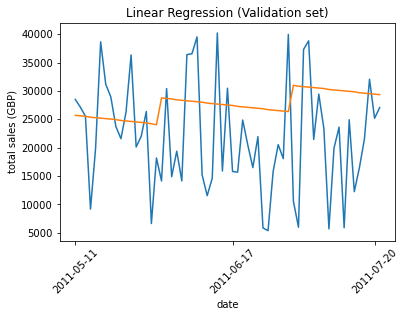

In [359]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_val_axis.index,y_val)
ax.plot(X_val_axis.index,val_preds)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title("Linear Regression (Validation set)")
plt.show()

Test set

In [360]:
#test set 
# predict on the same period
test_preds = my_lr.predict(X_test)
mape = mean_absolute_percentage_error(y_test,test_preds)
print('mean absolute percentage error total:',mape)

mean absolute percentage error total: 0.6045921938967022


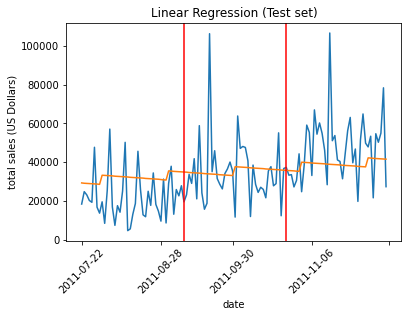

In [361]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_test_axis.index,y_test)
ax.plot(X_test_axis.index,test_preds)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (US Dollars)")
plt.title("Linear Regression (Test set)")
plt.axvline(x = 40, color = 'r', label = '40 days')
plt.axvline(x = 80, color = 'r', label = '80 days')
plt.show()

Split test data into 3 equal-sized segments:

In [362]:
test_preds_1 = my_lr.predict(X_test[:40])
mape1 = mean_absolute_percentage_error(y_test[:40], test_preds_1)
print('mean absolute percentage error (1st third)', mape1)

test_preds_2 = my_lr.predict(X_test[40:80])
mape2 = mean_absolute_percentage_error(y_test[40:80], test_preds_2)
print('mean absolute percentage error (2nd third)', mape2)

test_preds_3 = my_lr.predict(X_test[80:])
mape3 = mean_absolute_percentage_error(y_test[80:], test_preds_3)
print('mean absolute percentage error (3rd third)', mape3)

print('mean absolute percentage error combined:',(mape1 + mape2 + mape3) / 3)

mean absolute percentage error (1st third) 1.084912118982404
mean absolute percentage error (2nd third) 0.44237495938849714
mean absolute percentage error (3rd third) 0.2864895033192053
mean absolute percentage error combined: 0.6045921938967022


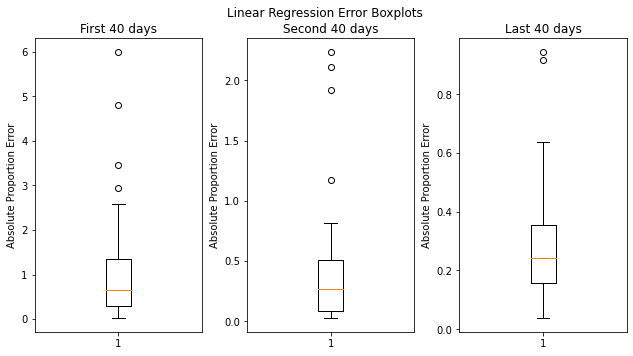

In [363]:
fig, axs = plt.subplots(1, 3, figsize=(9, 5))
fig.suptitle('Linear Regression Error Boxplots')
fig.tight_layout()

axs[0].boxplot(abs(y_test[:40] - test_preds_1) / y_test[:40])
axs[0].set_title('First 40 days')
axs[1].boxplot(abs(y_test[40:80] - test_preds_2) / y_test[40:80])
axs[1].set_title('Second 40 days')
axs[2].boxplot(abs(y_test[80:] - test_preds_3) / y_test[80:])
axs[2].set_title('Last 40 days')

plt.setp(axs, ylabel='Absolute Proportion Error')

plt.show()

Comment: Linear Regression is have some limitation to this data so the model has low learning ability

### Random Forest Regressor

In [364]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [40, 80, 120, 160, 200]
}

best_estimator = None
min_error = 1

for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        my_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
        my_rf.fit(X_train, y_train)
        
        rf_preds_val = my_rf.predict(X_val)
        mape = mean_absolute_percentage_error(y_val,rf_preds_val)
        
        if mape < min_error:
            min_error = mape
            best_estimator = my_rf
            
print(best_estimator)

RandomForestRegressor(max_depth=40, n_estimators=200, random_state=0)


Params selected from https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/ 

Training set

In [365]:
# fit the model
my_rf = best_estimator
my_rf.fit(X_train, y_train)

# predict on the same period
rf_preds = my_rf.predict(X_train)
# plot what has been learned
#plt.plot(daily_resampled.index, y)
#plt.plot(daily_resampled.index, rf_preds)
mape = mean_absolute_percentage_error(y_train,rf_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 0.19666379941725762


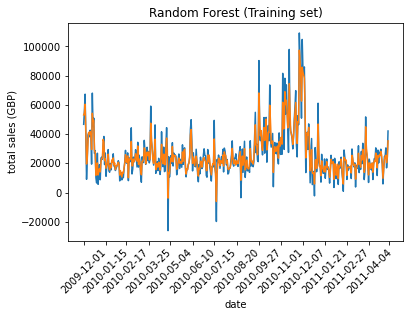

In [366]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_train_axis.index,y_train)
ax.plot(X_train_axis.index,rf_preds)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('Random Forest (Training set)')
plt.show()

Validation set

In [367]:
# predict on the same period
val_rf_preds = my_rf.predict(X_val)
# plot what has been learned
#plt.plot(daily_resampled.index, y)
#plt.plot(daily_resampled.index, rf_preds)
mape = mean_absolute_percentage_error(y_val,val_rf_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 0.5658018039828032


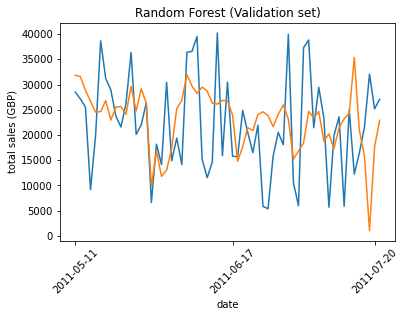

In [368]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_val_axis.index,y_val)
ax.plot(X_val_axis.index,val_rf_preds)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('Random Forest (Validation set)')
plt.show()

Test set

In [369]:
# predict on the same period
test_rf_preds = my_rf.predict(X_test)
# plot what has been learned
#plt.plot(daily_resampled.index, y)
#plt.plot(daily_resampled.index, rf_preds)
mape = mean_absolute_percentage_error(y_test,test_rf_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 0.5202710546640722


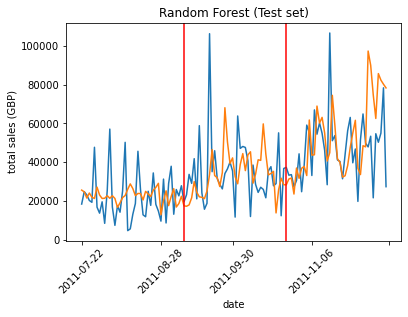

In [370]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_test_axis.index,y_test)
ax.plot(X_test_axis.index,test_rf_preds)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('Random Forest (Test set)')
plt.axvline(x = 40, color = 'r', label = '40 days')
plt.axvline(x = 80, color = 'r', label = '80 days')
plt.show()

Split test data into 3 equal-sized segments:

In [371]:
test_preds_1 = my_rf.predict(X_test[:40])
mape1 = mean_absolute_percentage_error(y_test[:40], test_preds_1)
print('mean absolute percentage error (1st third)', mape1)

test_preds_2 = my_rf.predict(X_test[40:80])
mape2 = mean_absolute_percentage_error(y_test[40:80], test_preds_2)
print('mean absolute percentage error (2nd third)', mape2)

test_preds_3 = my_rf.predict(X_test[80:])
mape3 = mean_absolute_percentage_error(y_test[80:], test_preds_3)
print('mean absolute percentage error (3rd third)', mape3)

print('mean absolute percentage error combined:',(mape1 + mape2 + mape3) / 3)

mean absolute percentage error (1st third) 0.6961239615102297
mean absolute percentage error (2nd third) 0.4797969758055676
mean absolute percentage error (3rd third) 0.38489222667641937
mean absolute percentage error combined: 0.5202710546640722


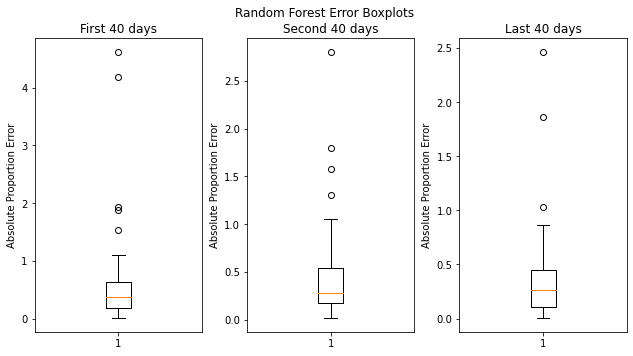

In [372]:
fig, axs = plt.subplots(1, 3, figsize=(9, 5))
fig.suptitle('Random Forest Error Boxplots')
fig.tight_layout()

axs[0].boxplot(abs(y_test[:40] - test_preds_1) / y_test[:40])
axs[0].set_title('First 40 days')
axs[1].boxplot(abs(y_test[40:80] - test_preds_2) / y_test[40:80])
axs[1].set_title('Second 40 days')
axs[2].boxplot(abs(y_test[80:] - test_preds_3) / y_test[80:])
axs[2].set_title('Last 40 days')

plt.setp(axs, ylabel='Absolute Proportion Error')

plt.show()

### XGBoost

In [373]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [374]:
import xgboost as xgb

param_grid = {
    'max_depth': np.arange(3, 11),
    'n_estimators': 100 * np.arange(11),
    'learning_rate': [0.01, 0.03, 0.1, 0.3],
    'colsample_bytree': 0.1 * np.arange(5, 11),
    'subsample': 0.1 * np.arange(6, 11)
}

# set random seed
np.random.seed(0)

best_estimator = None
min_error = 1

# random search
for _ in range(500):
    max_depth = np.random.choice(param_grid['max_depth'], )
    n_estimators = np.random.choice(param_grid['n_estimators'])
    learning_rate = np.random.choice(param_grid['learning_rate'])
    colsample_bytree = np.random.choice(param_grid['colsample_bytree'])
    subsample = np.random.choice(param_grid['subsample'])
    
    my_xgb = xgb.XGBRegressor(max_depth = max_depth, n_estimators=n_estimators, learning_rate=learning_rate, colsample_bytree=colsample_bytree, subsample=subsample, random_state=0)
    my_xgb.fit(X_train,y_train)

    xgb_preds_val = my_xgb.predict(X_val)
    mape = mean_absolute_percentage_error(y_val,xgb_preds_val)

    if mape < min_error:
        min_error = mape
        best_estimator = my_xgb
    
    
# # Grid search 
# for max_depth in param_grid['max_depth']:
#     for n_estimators in param_grid['n_estimators']:
#         for learning_rate in param_grid['learning_rate']:
#             for colsample_bytree in param_grid['colsample_bytree']:
#                 for subsample in param_grid['subsample']:
#                     my_xgb = xgb.XGBRegressor(max_depth = max_depth, n_estimators=n_estimators, learning_rate=learning_rate, colsample_bytree=colsample_bytree, subsample=subsample, random_state=0)
#                     my_xgb.fit(X_train,y_train)

#                     xgb_preds_val = my_xgb.predict(X_val)
#                     mape = mean_absolute_percentage_error(y_val,xgb_preds_val)

#                     if mape < min_error:
#                         min_error = mape
#                         best_estimator = my_xgb
            
print(best_estimator)                   

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)


Params chosen from https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

Training set:

In [375]:
# fit the model
my_xgb = best_estimator
my_xgb.fit(X_train,y_train)

# predict on the same period
xg_preds = my_xgb.predict(X_train)

#mae
mape = mean_absolute_percentage_error(y_train,xg_preds)
print('mean absolute percentage error:',mape)


mean absolute percentage error: 0.35277529989264417


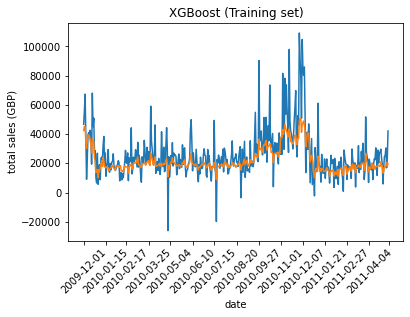

In [376]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_train_axis.index,y_train)
ax.plot(X_train_axis.index,xg_preds)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('XGBoost (Training set)')
plt.show()

Validation set:

In [377]:
# predict on the same period
val_xg_preds = my_xgb.predict(X_val)
# plot what has been learned
#plt.plot(daily_resampled.index, y)
#plt.plot(daily_resampled.index, rf_preds)
mape = mean_absolute_percentage_error(y_val,val_xg_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 0.44181850706574854


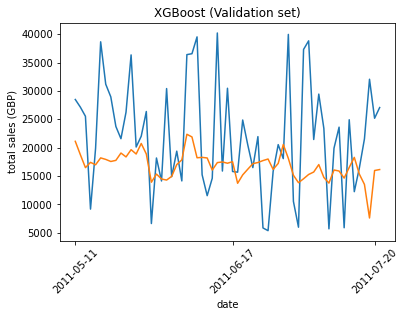

In [378]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_val_axis.index,y_val)
ax.plot(X_val_axis.index,val_xg_preds)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('XGBoost (Validation set)')
plt.show()

Test set:

In [379]:
# predict on the same period
test_xg_preds = my_xgb.predict(X_test)
# plot what has been learned
#plt.plot(daily_resampled.index, y)
#plt.plot(daily_resampled.index, rf_preds)
mape = mean_absolute_percentage_error(y_test,test_xg_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 0.37852050939914167


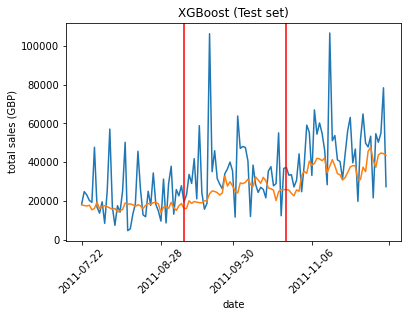

In [380]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_test_axis.index,y_test)
ax.plot(X_test_axis.index,test_xg_preds)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('XGBoost (Test set)')
plt.axvline(x = 40, color = 'r', label = '40 days')
plt.axvline(x = 80, color = 'r', label = '80 days')
plt.show()

Split test data into 3 equal-sized segments:

In [381]:
test_preds_1 = my_xgb.predict(X_test[:40])
mape1 = mean_absolute_percentage_error(y_test[:40], test_preds_1)
print('mean absolute percentage error (1st third)', mape1)

test_preds_2 = my_xgb.predict(X_test[40:80])
mape2 = mean_absolute_percentage_error(y_test[40:80], test_preds_2)
print('mean absolute percentage error (2nd third)', mape2)

test_preds_3 = my_xgb.predict(X_test[80:])
mape3 = mean_absolute_percentage_error(y_test[80:], test_preds_3)
print('mean absolute percentage error (3rd third)', mape3)

print('mean absolute percentage error combined:',(mape1 + mape2 + mape3) / 3)

mean absolute percentage error (1st third) 0.47935953004816423
mean absolute percentage error (2nd third) 0.3678026789411316
mean absolute percentage error (3rd third) 0.2883993192081292
mean absolute percentage error combined: 0.37852050939914167


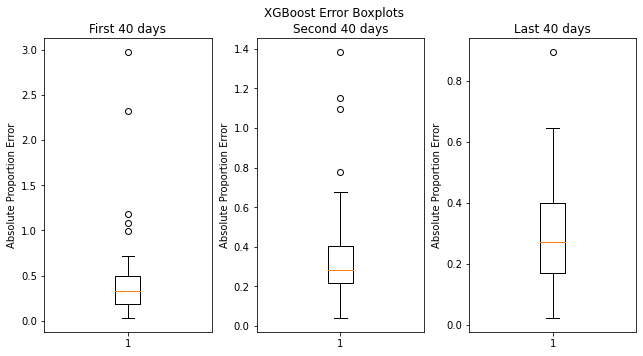

In [382]:
fig, axs = plt.subplots(1, 3, figsize=(9, 5))
fig.suptitle('XGBoost Error Boxplots')
fig.tight_layout()

axs[0].boxplot(abs(y_test[:40] - test_preds_1) / y_test[:40])
axs[0].set_title('First 40 days')
axs[1].boxplot(abs(y_test[40:80] - test_preds_2) / y_test[40:80])
axs[1].set_title('Second 40 days')
axs[2].boxplot(abs(y_test[80:] - test_preds_3) / y_test[80:])
axs[2].set_title('Last 40 days')

plt.setp(axs, ylabel='Absolute Proportion Error')

plt.show()

Comment: 



XGBOOST model has the lowest mean absolute error during the training.
We can see that the peak of total sales from 3 models prediction is around the end of the year or November-December which is correlate with the EDA we performed earlier. 

In [30]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


# SARIMA Model

In [383]:
#SARIMA Model
import warnings
import itertools
import statsmodels.api as sm
import pmdarima as pm

param=(2,1,3)
param_seasonal=(2,1,3,12)

mod = sm.tsa.statespace.SARIMAX(y_train, order=param, seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()

print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

/Users/michaelzhou/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(2, 1, 3, 12)12 - AIC:8138.774610700254


In [384]:
#Let's fit the model to our data
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0, 1, 1),
                                seasonal_order=(2, 1, 0, 12))
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 10.673121
         Iterations: 2
         Function evaluations: 98
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6643      0.035    -18.771      0.000      -0.734      -0.595
ar.S.L12      -0.6321      0.039    -16.241      0.000      -0.708      -0.556
ar.S.L24      -0.2787      0.039     -7.223      0.000      -0.354      -0.203
sigma2      2.142e+08   6.93e-11   3.09e+18      0.000    2.14e+08    2.14e+08


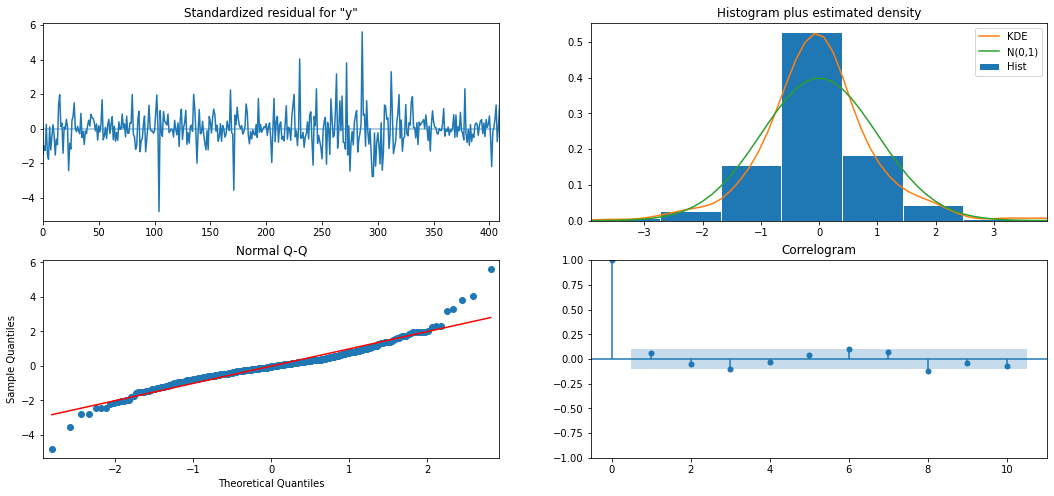

In [385]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

Hence, we can tell that the residuals are uncorrelated and that they have zero mean. So the model is properly fitted.